In [1]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.spatial.distance import braycurtis
%matplotlib inline

# Read taxonomy

In [2]:
df_tax = pd.read_csv('../../databases/HMPv35/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy
0,9f0b677374166540a820720de4b5c497,Bacteria;Actinobacteriota;Actinobacteria;Propi...,0.999997,Cutibacterium
1,289741fd8c1b48bfc357686cdb16fb1d,Bacteria;Firmicutes;Bacilli;Lactobacillales;St...,0.999985,Streptococcus
2,b2c534e7cecc5f7533915c3ef4f14c22,Bacteria;Firmicutes;Bacilli;Lactobacillales;St...,0.999970,Streptococcus
3,af972eec0b31108567dc3ceaacbcb05d,Bacteria;Firmicutes;Bacilli;Lactobacillales;St...,1.000000,Streptococcus
4,22958f3bf8531f673abde4fba80641ae,Bacteria;Proteobacteria;Gammaproteobacteria;Bu...,0.999945,Neisseria


# Read metadata

In [16]:
df_meta = pd.read_csv("../../databases/HMPv35/metadata.txt", sep="\t", index_col=0)
df_meta['host_visit_id'] = [str(x)+'_'+str(y) for x,y in zip(df_meta.host_subject_id, df_meta.visit_no)]
df_meta = df_meta[df_meta.env.isin(['gastrointestinal_tract','oral_cavity'])]
df_meta.head()

,env,body_site,env_material,psn,sequence_center,host_subject_id,biosample_accession,visit_no,gender,host_visit_id
sample_id,,,,,,,,,,
SRS021079,oral_cavity,hard_palate,sebum,700096626,JCVI,160866180,SAMN00042297,1.0,Female,160866180_1.0
SRS023256,oral_cavity,hard_palate,sebum,700099414,JCVI,964271349,SAMN00044474,NaN,NaN,964271349_nan
SRS050571,oral_cavity,attached keratinized_gingiva,sebum,700108876,BCM,160603188,SAMN00070580,2.0,Male,160603188_2.0
SRS065236,oral_cavity,subgingival_plaque,organic material,700113523,WUGSC,763719065,SAMN00084260,2.0,Female,763719065_2.0
SRS057300,oral_cavity,buccal_mucosa,sebum,700038771,WUGSC,508703490,SAMN00077309,1.0,Female,508703490_1.0


# Read count data (filter out samples with less than 1000 reads)

In [4]:
df_count = pd.read_csv('../../databases/HMPv35/feature_table.txt', sep="\t", index_col=0)
df_count = df_count.loc[df_tax['ASV']].T
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_meta.index).intersection(set(sample_ids_w_suff_reads))]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum total count = %d" % df_count.sum(axis=1).min())
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum total count = 1009


#OTU ID,9f0b677374166540a820720de4b5c497,289741fd8c1b48bfc357686cdb16fb1d,b2c534e7cecc5f7533915c3ef4f14c22,af972eec0b31108567dc3ceaacbcb05d,22958f3bf8531f673abde4fba80641ae,43d63e540470fb5bfbe3fd4cb1f9cecf,47c6886e2a9b01dba19ed501877f3275,ad070cf8732b1266da50e879f4b385c1,299c141b8b33629bbf60b183b0185285,b26c46a877e7a7644e295a5d4dc5f053,...,3a1d415cc5320bfb405c681a7f65b96c,b8c305118313f632b3e4d0c675e572a1,a6549becdc7ee00d9760f7ea6b45fe7b,01f578a47fcdfd2fa45eeccf81807ca8,1fafb1a6a0f8f00dad6a46894c7b7655,31aca8d04471a59da24100ad2691b45c,df31f76f9fb977c81601b002aeaccee5,799e3b7aac70efad46a6b18522707d09,6110793b9360904298285d0ef873c788,822dc6489cee23ca376c8398df0093ab
SRS018096,0.0000,0.000000,0.000000,0.007965,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS016355,0.0000,0.028932,0.000000,0.109050,0.000000,0.063056,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS022115,0.0000,0.000000,0.000000,0.049885,0.000000,0.076548,0.0,0.0,0.024943,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS048480,0.0000,0.000000,0.092691,0.000000,0.001268,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS024159,0.0017,0.000000,0.000000,0.013885,0.032020,0.018419,0.0,0.0,0.079059,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Compare different oral fraction estimation methods

In [5]:
df_blast_HOMD = pd.read_csv("../../databases/HMPv35/blast_HOMD/blast_HOMD_p100.txt", sep="\t", comment="#", header=None)
df_blast_HOMD.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

df_blast_fHOMD = pd.read_csv("../../databases/HMPv35/blast_fHOMD/blast_fHOMD_p100.txt", sep="\t", comment="#", header=None)
df_blast_fHOMD.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

df_blast_HMPv35oral = pd.read_csv("../../databases/HMPv35/blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_HMPv35oral.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

In [6]:
all_visits = set(df_meta.host_visit_id)
res = []
for visit in all_visits:
    curr_df = df_meta[df_meta.host_visit_id == visit]
    curr_df = curr_df.loc[set(curr_df.index).intersection(df_relabun.index)]
    if 'stool' not in list(curr_df.body_site):
        continue
    else:
        gut_sample_id = list(curr_df[curr_df.body_site=='stool'].index)
        assert len(gut_sample_id) == 1
        gut_sample_id = gut_sample_id[0]
    # we only consider patients with paired oral and gut samples
    oral_sample_id = list(curr_df[curr_df.body_site.isin(['attached keratinized_gingiva','buccal_mucosa','hard_palate',
                                                          'palatine_tonsils','saliva','subgingival_plaque','supragingival_plaque',
                                                          'throat','tongue_dorsum'])].index)
    if len(oral_sample_id) == 0:
        continue
    
    # oral sequences
    df_oral_seqs = df_relabun.loc[oral_sample_id]
    oral_seqs = list(df_oral_seqs.mean(axis=0)[df_oral_seqs.mean(axis=0)>0].index)
    
    # HOMD, all hits
    HOMD_hit = set(df_blast_HOMD.query_accver).intersection(set(df_relabun.columns))
    oral_frac_HOMD = df_relabun.loc[gut_sample_id, HOMD_hit].sum()
    
    # HOMD, hits present in oral cavity
    oral_seqs_w_HOMD_hit = set(oral_seqs).intersection(set(df_blast_HOMD.query_accver).intersection(set(df_relabun.columns)))
    oral_frac_HOMD_overlap = df_relabun.loc[gut_sample_id, oral_seqs_w_HOMD_hit].sum()
    
    # fHOMD, all hits
    fHOMD_hit = set(df_blast_fHOMD.query_accver).intersection(set(df_relabun.columns))
    oral_frac_fHOMD = df_relabun.loc[gut_sample_id, fHOMD_hit].sum()
    
    # fHOMD, hits present in oral cavity
    oral_seqs_w_fHOMD_hit = set(oral_seqs).intersection(set(df_blast_fHOMD.query_accver).intersection(set(df_relabun.columns)))
    oral_frac_fHOMD_overlap = df_relabun.loc[gut_sample_id, oral_seqs_w_fHOMD_hit].sum()
    
    # HMPv35oral, all hits
    HMPv35oral_hit = set(df_blast_HMPv35oral.query_accver).intersection(set(df_relabun.columns))
    oral_frac_HMPv35oral = df_relabun.loc[gut_sample_id, HMPv35oral_hit].sum()
    
    # HMPv35oral, hits present in oral cavity
    oral_seqs_w_HMPv35oral_hit = set(oral_seqs).intersection(set(df_blast_HMPv35oral.query_accver).intersection(set(df_relabun.columns)))
    oral_frac_HMPv35oral_overlap = df_relabun.loc[gut_sample_id, oral_seqs_w_HMPv35oral_hit].sum()
    
    if oral_frac_HOMD==0:
        res.append([gut_sample_id, 'HOMD', oral_frac_HOMD, 1.0])
    else:
        res.append([gut_sample_id, 'HOMD', oral_frac_HOMD, oral_frac_HOMD_overlap/oral_frac_HOMD])
        
    if oral_frac_fHOMD==0:
        res.append([gut_sample_id, 'fHOMD', oral_frac_fHOMD, 1.0])
    else:
        res.append([gut_sample_id, 'fHOMD', oral_frac_fHOMD, oral_frac_fHOMD_overlap/oral_frac_fHOMD])
        
    if oral_frac_HMPv35oral==0:
        res.append([gut_sample_id, 'HMPv35oral', oral_frac_HMPv35oral, 1.0])
    else:
        res.append([gut_sample_id, 'HMPv35oral', oral_frac_HMPv35oral, oral_frac_HMPv35oral_overlap/oral_frac_HMPv35oral])

df_res = pd.DataFrame(res, columns=['SampleID','Method','OralFrac','FracInOralSample']).set_index('SampleID')
df_res.head()

,Method,OralFrac,FracInOralSample
SampleID,,,
SRS011415,HOMD,0.001391,1.0
SRS011415,fHOMD,0.001391,1.0
SRS011415,HMPv35oral,0.001391,1.0
SRS015724,HOMD,0.000227,0.0
SRS015724,fHOMD,0.000000,1.0


In [7]:
len(set(df_res.index))

280

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 76.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 95.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 93.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


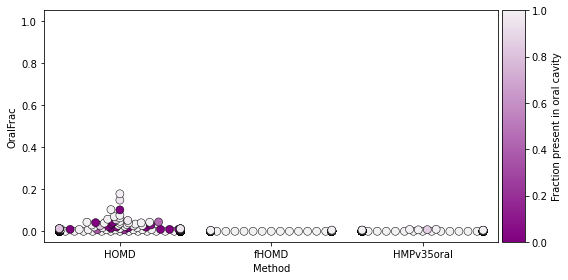

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

#Create a matplotlib colormap from the sns purple color palette
cmap    = sns.light_palette("purple", reverse=True, as_cmap=True )
# Normalize to the range of possible values from df["c"]
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
# create a color dictionary (value in c : color from colormap) 
colors = {}
for cval in df_res.FracInOralSample:
    colors.update({cval : cmap(norm(cval))})
    
_ = sns.swarmplot(x="Method", y="OralFrac", data=df_res, ax=ax, order=['HOMD','fHOMD','HMPv35oral'], size=6, hue='FracInOralSample', palette = colors, s=8, edgecolor='k', linewidth=0.5)
_ = ax.set_ylim([-0.02,0.2])
plt.gca().legend_.remove()

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Fraction present in oral cavity')
_ = ax.set_ylim([-0.05,1.05])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("compare_oral_estimation_methods.svg", dpi=600, bbox_inches='tight')

# Mean relative abundance of oral bacteria in healthy people

In [27]:
df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='gastrointestinal_tract'].index)), 
               set(df_relabun.columns).intersection(set(df_blast_HMPv35oral.query_accver))].sum(axis=1).mean()

0.0005003651255655417

## Correlate oral bacterial fraction and sequencing depth

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


SpearmanrResult(correlation=0.27684514090283935, pvalue=2.5505735984681135e-06)


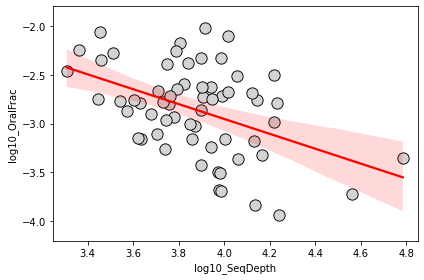

In [73]:
# compute sequence depth
df_count_sum = pd.merge(df_meta[df_meta.body_site=='stool'], df_count.sum(axis=1).to_frame().rename({0:'SeqDepth'}, axis=1), left_index=True, right_index=True, how='inner')
df_count_sum = pd.merge(df_count_sum, df_relabun[set(df_relabun.columns).intersection(set(df_blast_HMPv35oral.query_accver))].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1),
                        left_index=True, right_index=True, how='inner')
df_count_sum = df_count_sum.loc[set(df_res.index)]
df_count_sum['log10_SeqDepth'] = np.log10(df_count_sum['SeqDepth'])
df_count_sum['log10_OralFrac'] = np.log10(df_count_sum['OralFrac'])

# spearman correlation
print(spearmanr(df_count_sum.SeqDepth, df_count_sum.OralFrac))

fig, ax = plt.subplots(figsize=(6,4))
_ = sns.scatterplot(x="log10_SeqDepth", y="log10_OralFrac", data=df_count_sum[df_count_sum.OralFrac>0], ax=ax, s=128, color='lightgray', edgecolor='k')
_ = sns.regplot(x="log10_SeqDepth", y="log10_OralFrac", data=df_count_sum[df_count_sum.OralFrac>0], ax=ax, scatter=False, color="red")
_ = ax.set_ylim([-4.2,-1.8])
_ = ax.set_xlim([3.25,4.85])
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scatterplot_depth_vs_oral_fraction.svg", dpi=600, bbox_inches='tight')